In [1]:
from gensim.models import Word2Vec

In [2]:
# pip install gensim

In [3]:
# pip install emoji

In [5]:
# pip install pymorphy3

In [27]:
import os
import re
import string
import random
from collections import Counter, OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import emoji
import pymorphy3
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW, lr_scheduler

from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    get_linear_schedule_with_warmup,
    pipeline
)

from tqdm import tqdm
from google.colab import drive


**Для воспроизводимости результатов зафиксируем зерно**

In [7]:
def setup_random_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

setup_random_seed()

In [8]:
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/dl_hw_2")
!ls

Mounted at /content/drive
comp2.ipynb  submission_df_text_cnn_.csv  test.csv	training_output
logs	     submission_df_w2v.csv	  tiny_results
my_models    submission_tfidf.csv	  train.csv


In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [10]:
train.head()

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0


## Анализ данных

In [11]:
label_matrix = np.array([list(map(int, train['labels'].iloc[i].split())) for i in range(len(train))])
print("Общее количество классов:",label_matrix.shape[1])

Общее количество классов: 20


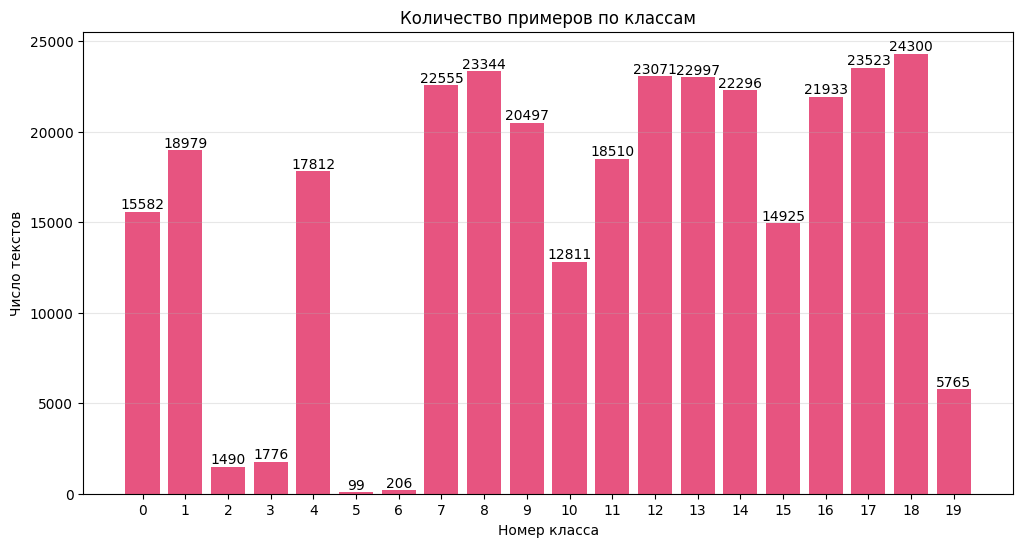

Топ-3 самых частых классов: [18 17  8]
Топ-3 самых редких классов: [5 6 2]


In [12]:
class_counts = label_matrix.sum(axis=0)
class_numbers = np.arange(len(class_counts))

plt.figure(figsize=(12, 6))
bars = plt.bar(class_numbers, class_counts, color='#e75480')

plt.xticks(class_numbers, class_numbers)
plt.title("Количество примеров по классам")
plt.xlabel("Номер класса")
plt.ylabel("Число текстов")
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.show()

print("Топ-3 самых частых классов:", np.argsort(class_counts)[-3:][::-1])
print("Топ-3 самых редких классов:", np.argsort(class_counts)[:3])

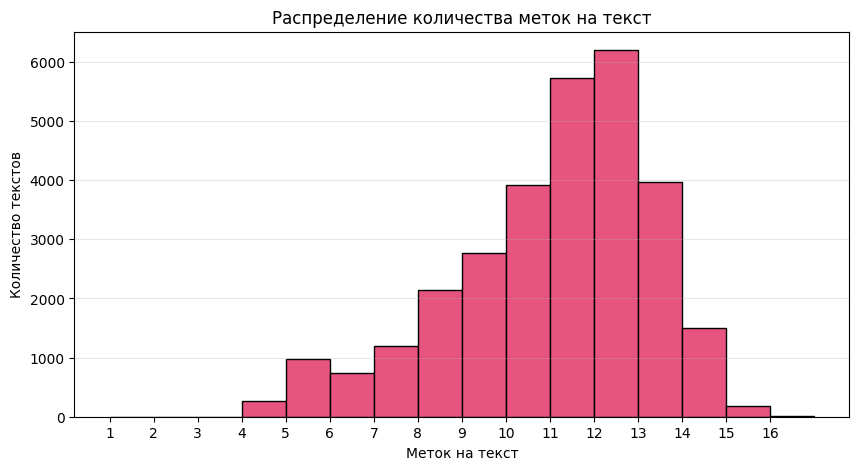

Среднее меток на текст: 10.567877435064934
Максимальное количество меток на текст: 16


In [13]:
labels_per_text = label_matrix.sum(axis=1)

plt.figure(figsize=(10, 5))
plt.hist(labels_per_text, bins=range(1, labels_per_text.max()+2),color='#e75480', edgecolor='black')
plt.title("Распределение количества меток на текст")
plt.xlabel("Меток на текст")
plt.ylabel("Количество текстов")
plt.xticks(range(1, labels_per_text.max()+1))
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Среднее меток на текст:",labels_per_text.mean())
print("Максимальное количество меток на текст:",labels_per_text.max())

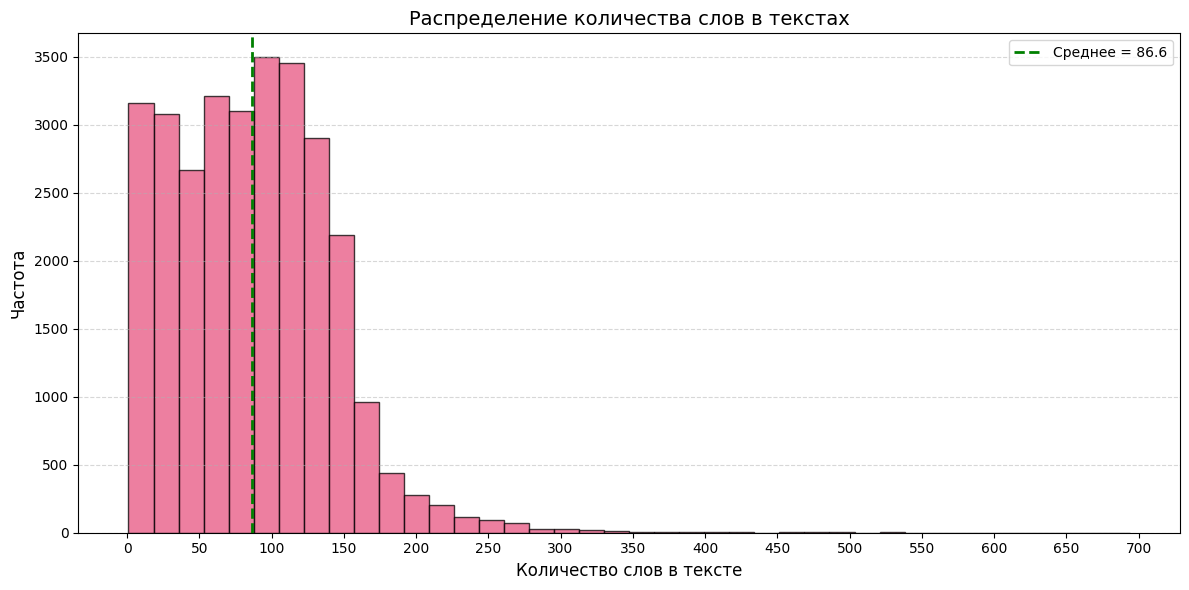

Средняя длина: 86.61
Минимум слов: 1
Максимум слов: 694


In [14]:
text_lengths = train['text'].str.split().str.len()

plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=40, color='#e75480', alpha=0.75, edgecolor='black')

mean_length = text_lengths.mean()
plt.axvline(mean_length, color='green', linestyle='--', linewidth=2, label=f'Среднее = {mean_length:.1f}')

plt.title("Распределение количества слов в текстах", fontsize=14)
plt.xlabel("Количество слов в тексте", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.xticks(range(0, int(text_lengths.max()) + 50, 50))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Средняя длина: {mean_length:.2f}")
print(f"Минимум слов: {text_lengths.min()}")
print(f"Максимум слов: {text_lengths.max()}")

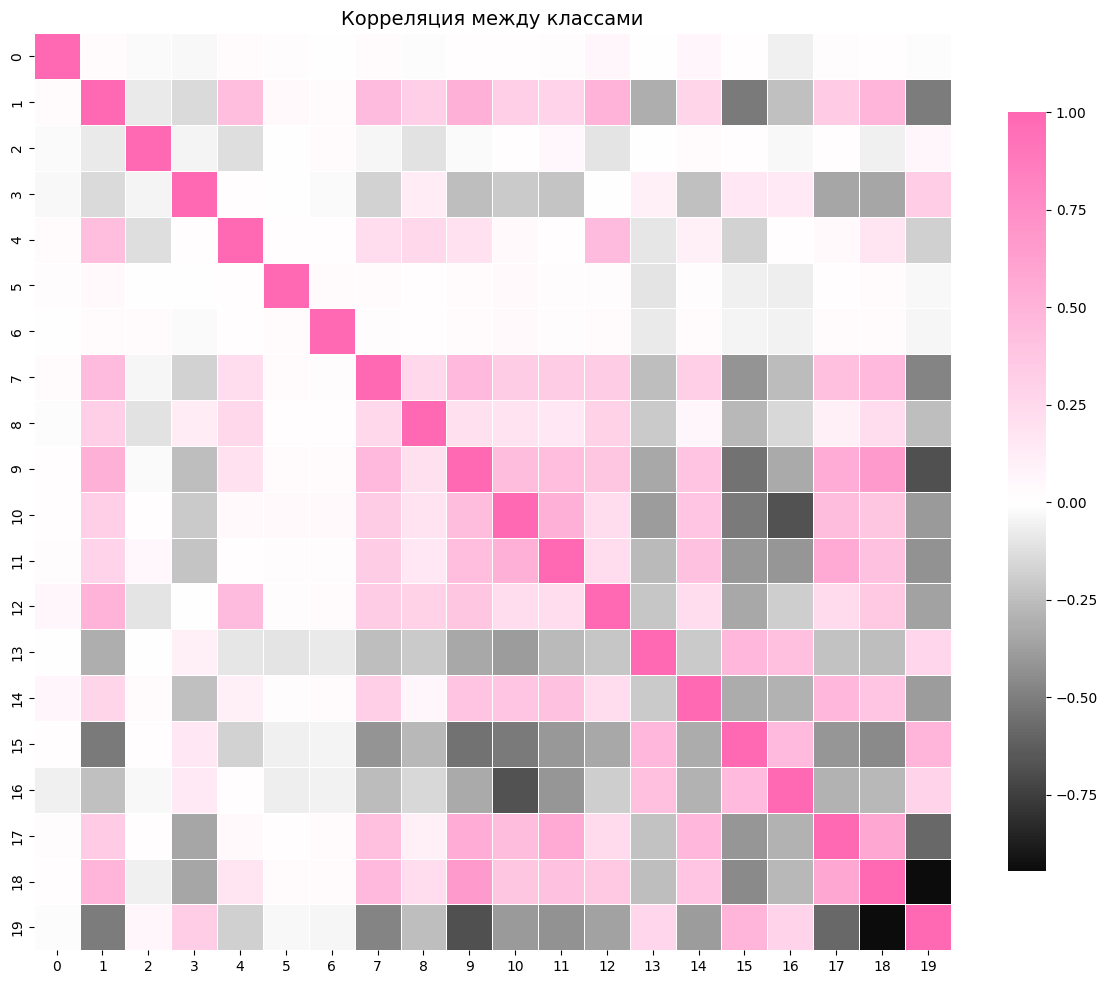

In [15]:
correlation_matrix = pd.DataFrame(label_matrix).corr()

custom_cmap = LinearSegmentedColormap.from_list(
    name="pink_black",
    colors=["black", "white", "#ff69b4"],
    N=256
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    cmap=custom_cmap,
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5,
    linecolor='white'
)

plt.title("Корреляция между классами", fontsize=14)
plt.tight_layout()
plt.show()

In [16]:
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

extra_stopwords = ['который', 'очень', 'свой', 'весь', 'когда', 'прямо']
all_stopwords = set(russian_stopwords + extra_stopwords)

def clean_text(text):
    words = re.findall(r'\b[а-яё]{3,}\b', text.lower())
    return [word for word in words if word not in all_stopwords]

class_word_counts = {i: Counter() for i in range(label_matrix.shape[1])}

for class_idx in range(label_matrix.shape[1]):
    class_texts = train[label_matrix[:, class_idx] == 1]['text']

    for text in class_texts:
        words = clean_text(str(text))
        class_word_counts[class_idx].update(words)

print("Топ-5 характерных слов по классам:")
for class_idx in sorted(class_word_counts.keys()):
    top_words = class_word_counts[class_idx].most_common(5)
    print(f"\nКласс {class_idx} ({class_counts[class_idx]} примеров):")
    for word, count in top_words:
        print(f"  {word}: {count} раз")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Топ-5 характерных слов по классам:

Класс 0 (15582 примеров):
  билеты: 8645 раз
  это: 4245 раз
  ссылке: 4180 раз
  промокоду: 4118 раз
  спектакль: 3843 раз

Класс 1 (18979 примеров):
  билеты: 16828 раз
  промокоду: 8827 раз
  ссылке: 7007 раз
  спектакль: 6728 раз
  это: 6344 раз

Класс 2 (1490 примеров):
  билеты: 936 раз
  это: 919 раз
  спектакль: 775 раз
  промокоду: 430 раз
  шоу: 375 раз

Класс 3 (1776 примеров):
  билеты: 729 раз
  хиты: 443 раз
  концерт: 378 раз
  рок: 367 раз
  промокоду: 360 раз

Класс 4 (17812 примеров):
  билеты: 13809 раз
  промокоду: 7272 раз
  ссылке: 5836 раз
  спектакль: 5252 раз
  концерт: 4450 раз

Класс 5 (99 примеров):
  пятигорск: 142 раз
  билеты: 134 раз
  стоимость: 125 раз
  года: 94 раз
  театр: 93 раз

Класс 6 (206 примеров):
  билеты: 130 раз
  спектакль: 119 раз
  семьи: 111 раз
  семейный: 100 раз
  россии: 95 раз

Класс 7 (22555 примеров):
  билеты: 18541 раз
  промокоду: 9604 раз
  спектакль: 7760 раз
  ссылке: 7523 раз
  это: 742

**Очистка и предобработка текста**

In [17]:
class TextCleaner:
    def __init__(self, lang="ru", keep_digits=False, yo_fix=True, min_word_len=1):
        self.analyzer = pymorphy3.MorphAnalyzer(lang=lang)
        self.stopwords = set(stopwords.words("russian")) | set(stopwords.words("english"))
        self.keep_digits = keep_digits
        self.normalize_yo = yo_fix
        self.min_len = min_word_len

    def __call__(self, item):
        content = item.get("text", "")
        if not isinstance(content, str) or not content.strip():
            return {**item, "text": ""}

        text = content.lower()

        if self.normalize_yo:
            text = text.replace("ё", "е")

        text = text.replace("\n", " ")
        text = re.sub(r"https?://\S+|www\.\S+", "", text)
        text = emoji.replace_emoji(text, "")

        p_table = str.maketrans(string.punctuation, " " * len(string.punctuation))
        text = text.translate(p_table)

        pattern = r"[^a-zа-я0-9\s]" if self.keep_digits else r"[^a-zа-я\s]"
        text = re.sub(pattern, "", text)

        words = text.split()
        normal = []

        for word in words:
            try:
                form = self.analyzer.parse(word)[0].normal_form
                normal.append(form)
            except:
                continue

        filtered = [w for w in normal if len(w) >= self.min_len and w not in self.stopwords]
        result = " ".join(filtered)

        labels = item.get("labels")
        final_labels = []

        if isinstance(labels, str) and labels.strip():
            try:
                final_labels = list(map(int, labels.split()))
            except:
                pass
        elif isinstance(labels, (list, tuple)):
            final_labels = [int(l) for l in labels if str(l).isdigit()]

        return {**item, "text": result, "labels": final_labels}

In [18]:
cleaner = TextCleaner(min_word_len=2)

cleaned_train = train.copy()
cleaned_test = test.copy()

cleaned_train["text"] = cleaned_train["text"].apply(lambda t: cleaner({"text": t})["text"])
cleaned_test["text"] = cleaned_test["text"].apply(lambda t: cleaner({"text": t})["text"])

In [17]:
cleaned_train

,id,text,labels
0,0,январь детский развлекательный программа беспл...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,август выходной мег мегапарк,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,йокнапатоф постановка театр маяковский билет,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,впервые уфа танцевальный терапия группа практи...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,grand piano competition друг сегодня открытие ...,1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,выступление симфо группа teodor июль парка мег...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,юзикл монт кристо театр оперетта это очень ярк...,1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,расписание бесплатный экскурсия октябрь год ки...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,долгожданный концерт надежда кадышева рязань с...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


**Приступаем к любимой части моделей...**

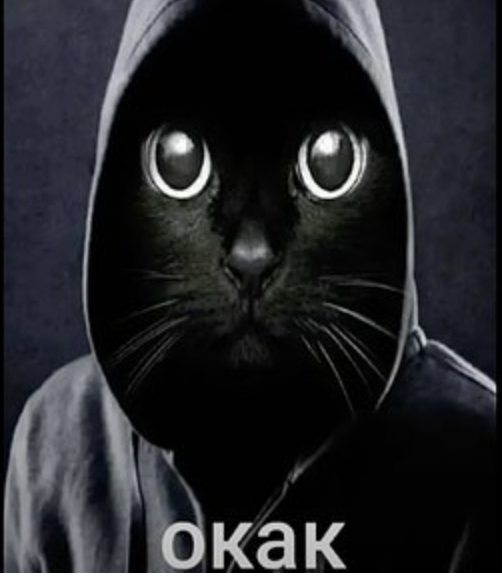

In [19]:
train_part, val_part = train_test_split(cleaned_train, test_size=0.2, random_state=42)

In [20]:
train_part_texts = train_part["text"]
train_part_labels = train_part["labels"]

val_part_texts = val_part["text"]
val_part_labels = val_part["labels"]

test_texts = cleaned_test["text"]

## TF-IDF

In [28]:
tfidf_vec = TfidfVectorizer(
    max_features=10000,  # пусть будет максимум 10 000 слов в словаре
    min_df=2,            # игнорирую слова, встречающиеся менее чем в 2 документах
    max_df=0.95          # игнорирую слова, встречающиеся более чем в 95% документов
)

tfidf_vec.fit(train_part_texts)

TfidfVectorizer(max_df=0.95, max_features=10000, min_df=2)

In [40]:
X_train_sparse = tfidf_vec.transform(train_part_texts)
X_val_sparse = tfidf_vec.transform(val_part_texts)

In [41]:
def prepare_dataloader(features_sparse, labels_str_series, batch_size=64, shuffle=True):
    features_tensor = torch.FloatTensor(features_sparse.todense())

    labels_list = labels_str_series.apply(lambda x: list(map(int, x.split())))
    labels_np = np.vstack(labels_list.values)
    labels_tensor = torch.tensor(labels_np, dtype=torch.float32)

    dataset = TensorDataset(features_tensor, labels_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = prepare_dataloader(X_train_sparse, train_part_labels)
val_loader = prepare_dataloader(X_val_sparse, val_part_labels, shuffle=False)

In [31]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_units=256):
        super().__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_units)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_units, output_size)

    def forward(self, inputs):
        x = self.hidden_layer(inputs)
        x = self.activation(x)
        logits = self.output_layer(x)
        return logits

**Отдельные функции для эпохи обучения и оценки**

In [32]:
def run_training_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x).squeeze(1)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)

    avg_loss = epoch_loss / len(dataloader.dataset)
    return avg_loss

In [33]:
def run_validation_epoch(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0.0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x).squeeze(1)
            loss = loss_fn(output, batch_y)
            val_loss += loss.item() * batch_x.size(0)
            preds_prob = torch.sigmoid(output)
            preds = (preds_prob > 0.5).int()
            all_targets.append(batch_y.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    avg_loss = val_loss / len(dataloader.dataset)
    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)
    val_f1_macro = f1_score(all_targets, all_preds, average="macro", zero_division=0)
    return avg_loss, val_f1_macro

**Главная функция обучения с логикой переключения, ранней остановки и шедулером**

In [34]:
def model_training(
    neural_net,
    train_loader,
    valid_loader,
    loss_function,
    primary_optim,
    max_epochs,
    secondary_optim=None,
    tracked_metric="f1_macro",
    switch_after=5,
    stop_early=None,
    lr_adjuster=None,
    save_path="top_model.pt",
    compute_device="cpu",
):

    neural_net.to(compute_device)

    active_optim = primary_optim
    active_scheduler = lr_adjuster

    training_log = {
        "training_loss": [],
        "validation_loss": [],
        "validation_f1": []
    }

    if tracked_metric == "f1_macro":
        optimal_value = -float('inf')
        is_better = lambda x, y: x > y
        metric_name = "F1-score (macro)"
    else:
        optimal_value = float('inf')
        is_better = lambda x, y: x < y
        metric_name = "Validation Loss"

    no_improvement_count = 0
    optimizer_changed = False
    peak_epoch = 0

    for current_epoch in range(1, max_epochs + 1):
        print(f"\n Начало эпохи {current_epoch}/{max_epochs}")
        print(f"│ Оптимизатор: {active_optim.__class__.__name__}")
        print(f"│ Скорость обучения: {active_optim.param_groups[0]['lr']:.2e}")

        epoch_loss = run_training_epoch(
            neural_net, train_loader, loss_function, active_optim, compute_device
        )
        training_log["training_loss"].append(epoch_loss)

        valid_loss, valid_f1 = run_validation_epoch(
            neural_net, valid_loader, loss_function, compute_device
        )
        training_log["validation_loss"].append(valid_loss)
        training_log["validation_f1"].append(valid_f1)

        print(f"\n├── Результаты:")
        print(f"│   Ошибка обучения: {epoch_loss:.4f}")
        print(f"│   Ошибка валидации: {valid_loss:.4f}")
        print(f"│   F1-мера: {valid_f1:.4f}")

        current_metric = valid_f1 if tracked_metric == "f1_macro" else valid_loss

        if is_better(current_metric, optimal_value):
            optimal_value = current_metric
            no_improvement_count = 0
            peak_epoch = current_epoch
            save_model(neural_net, save_path)
            print(f"\n└──  Новый рекорд {metric_name}: {optimal_value:.4f}!")
        else:
            no_improvement_count += 1
            print(f"\n└──  Без улучшений {no_improvement_count}/{switch_after}")

        if (not optimizer_changed and secondary_optim and
            no_improvement_count >= switch_after):
            print("\n Активация резервного оптимизатора!")
            active_optim = secondary_optim
            optimizer_changed = True
            no_improvement_count = 0
            active_scheduler = None
            print(f"Используется {active_optim.__class__.__name__}")

        if active_scheduler:
            active_scheduler.step()
            print(f"Обновлен learning rate: {active_optim.param_groups[0]['lr']:.2e}")

        if stop_early and no_improvement_count >= stop_early:
            print(f"\n Прекращение обучения после {no_improvement_count} эпох без улучшений")
            break

    if os.path.exists(save_path):
        neural_net.load_state_dict(torch.load(save_path))
        print(f"\n✔ Загружены веса из эпохи {peak_epoch} с {metric_name} {optimal_value:.4f}")

    return {
        "model": neural_net,
        "history": training_log,
        "best_epoch": peak_epoch,
        "best_score": optimal_value
    }

def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)

**Визуализация результатов**

In [35]:
def visualize_training_progress(training_stats, highlight_epoch):
    available_styles = plt.style.available
    preferred_styles = ['seaborn-v0_8', 'seaborn', 'ggplot', 'bmh', 'fivethirtyeight']
    selected_style = None

    for style in preferred_styles:
        if style in available_styles:
            selected_style = style
            break

    if selected_style:
        plt.style.use(selected_style)
    else:
        plt.style.use('default')

    epoch_count = len(training_stats["training_loss"])
    epochs_range = np.arange(1, epoch_count + 1)

    fig, (loss_ax, metric_ax) = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Анализ процесса обучения', y=1.02, fontsize=16, fontweight='bold')

    palette = {
        'train': '#e63946',
        'valid': '#457b9d',
        'highlight': '#1d3557',
        'metric': '#588157'
    }

    loss_ax.plot(epochs_range, training_stats["training_loss"],
                label='Ошибка обучения',
                color=palette['train'],
                linewidth=2.5,
                marker='o', markersize=7)

    loss_ax.plot(epochs_range, training_stats["validation_loss"],
                label='Ошибка валидации',
                color=palette['valid'],
                linewidth=2.5,
                marker='s', markersize=7)

    loss_ax.axvline(highlight_epoch, color=palette['highlight'],
                   linestyle='--',
                   linewidth=2,
                   label=f'Лучшая эпоха ({highlight_epoch})')

    min_val_loss = min(training_stats["validation_loss"])
    min_epoch = training_stats["validation_loss"].index(min_val_loss) + 1
    loss_ax.annotate(f'Лучшее: {min_val_loss:.4f}',
                    xy=(min_epoch, min_val_loss),
                    xytext=(min_epoch, min_val_loss + 0.1),
                    ha='center',
                    color=palette['highlight'],
                    fontsize=11,
                    arrowprops=dict(arrowstyle="->", color=palette['highlight']))

    loss_ax.set_title('Эволюция функции потерь', pad=15)
    loss_ax.set_xlabel('Эпохи', labelpad=10)
    loss_ax.set_ylabel('Значение потерь', labelpad=10)
    loss_ax.grid(True, alpha=0.3)
    loss_ax.legend(framealpha=1, shadow=True)

    metric_ax.plot(epochs_range, training_stats["validation_f1"],
                  label='F1-мера (макро)',
                  color=palette['metric'],
                  linewidth=2.5,
                  marker='^', markersize=7)

    metric_ax.axvline(highlight_epoch, color=palette['highlight'],
                     linestyle='--',
                     linewidth=2,
                     label=f'Лучшая эпоха ({highlight_epoch})')

    max_f1 = max(training_stats["validation_f1"])
    max_epoch = training_stats["validation_f1"].index(max_f1) + 1
    metric_ax.annotate(f'Пик: {max_f1:.4f}',
                      xy=(max_epoch, max_f1),
                      xytext=(max_epoch, max_f1 - 0.1),
                      ha='center',
                      color=palette['metric'],
                      fontsize=11,
                      arrowprops=dict(arrowstyle="->", color=palette['metric']))

    metric_ax.set_title('Динамика метрики качества', pad=15)
    metric_ax.set_xlabel('Эпохи', labelpad=10)
    metric_ax.set_ylabel('F1-мера (макро)', labelpad=10)
    metric_ax.grid(True, alpha=0.3)
    metric_ax.legend(framealpha=1, shadow=True)

    plt.tight_layout()
    plt.show()

**Обучение**

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Будем обучать на: {device}")

Будем обучать на: cuda



 Начало эпохи 1/10
│ Оптимизатор: AdamW
│ Скорость обучения: 1.00e-03

├── Результаты:
│   Ошибка обучения: 0.3627
│   Ошибка валидации: 0.2641
│   F1-мера: 0.7282

└──  Новый рекорд Validation Loss: 0.2641!
Обновлен learning rate: 9.94e-04

 Начало эпохи 2/10
│ Оптимизатор: AdamW
│ Скорость обучения: 9.94e-04

├── Результаты:
│   Ошибка обучения: 0.2237
│   Ошибка валидации: 0.2197
│   F1-мера: 0.7794

└──  Новый рекорд Validation Loss: 0.2197!
Обновлен learning rate: 9.76e-04

 Начало эпохи 3/10
│ Оптимизатор: AdamW
│ Скорость обучения: 9.76e-04

├── Результаты:
│   Ошибка обучения: 0.1771
│   Ошибка валидации: 0.2008
│   F1-мера: 0.7996

└──  Новый рекорд Validation Loss: 0.2008!
Обновлен learning rate: 9.46e-04

 Начало эпохи 4/10
│ Оптимизатор: AdamW
│ Скорость обучения: 9.46e-04

├── Результаты:
│   Ошибка обучения: 0.1472
│   Ошибка валидации: 0.1953
│   F1-мера: 0.8107

└──  Новый рекорд Validation Loss: 0.1953!
Обновлен learning rate: 9.05e-04

 Начало эпохи 5/10
│ Оптимизато

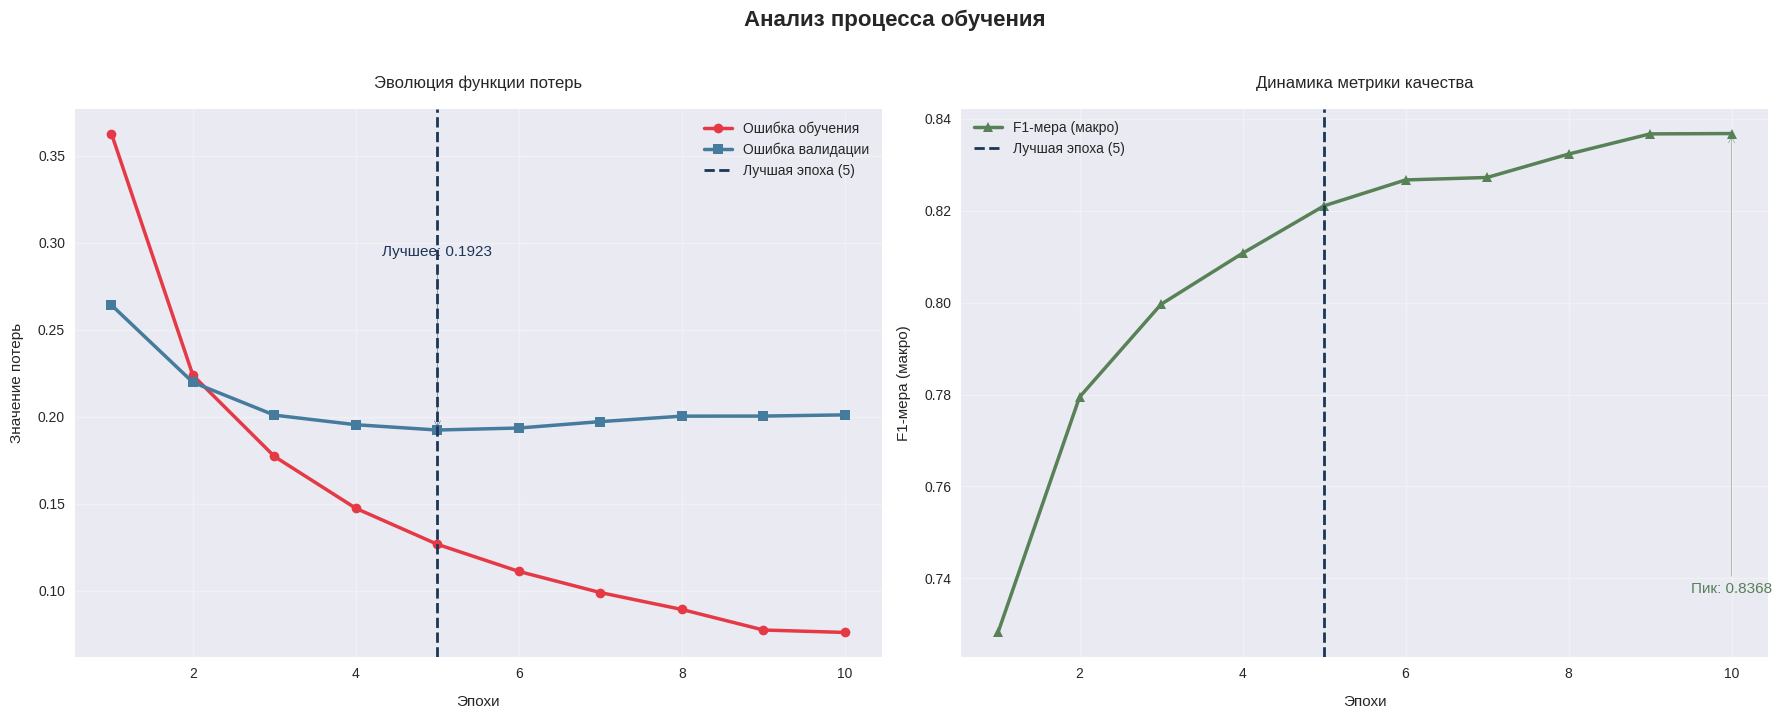

In [37]:
input_dim = X_train_sparse.shape[1]
output_dim = len(train_part_labels.iloc[0].split())

neural_net = FeedForwardNet(
    input_size=input_dim,
    output_size=output_dim,
    hidden_units=256,
)

loss_criterion = nn.BCEWithLogitsLoss()

primary_optimizer = optim.AdamW(neural_net.parameters(), lr=1e-3)
secondary_optimizer = optim.AdamW(neural_net.parameters(), lr=1e-4)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(primary_optimizer, T_max=20)

training_results = model_training(
    neural_net=neural_net,
    train_loader=train_loader,
    valid_loader=val_loader,
    loss_function=loss_criterion,
    primary_optim=primary_optimizer,
    max_epochs=10,
    secondary_optim=secondary_optimizer,
    tracked_metric="val_loss",
    switch_after=3,
    stop_early=5,
    lr_adjuster=lr_scheduler,
    save_path="my_models/my_best_tf_idf.pth",
    compute_device=device,
)

visualize_training_progress(
    training_stats=training_results["history"],
    highlight_epoch=training_results["best_epoch"]
)

In [38]:
def generate_submission(model, text_data, id_data, vectorizer, device='cpu', batch_size=64):
    model.to(device)
    model.eval()

    text_features = vectorizer.transform(text_data)
    features_tensor = torch.FloatTensor(text_features.todense())

    dataset = TensorDataset(features_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_preds = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            all_preds.append(preds.cpu())

    combined_preds = torch.cat(all_preds).numpy()
    str_labels = [' '.join(map(str, row)) for row in combined_preds]

    return pd.DataFrame({'id': id_data, 'labels': str_labels})

In [39]:
submission_df = generate_submission(
    model=training_results["model"],
    text_data=test_texts,
    id_data=cleaned_test["id"],
    vectorizer=tfidf_vec,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    batch_size=128
)

submission_df.to_csv('submission_tfidf.csv', index=False)

## W2V

In [60]:
def tokenize_texts(text_series):
    return [text.split() if isinstance(text, str) else ["[MISSING]"]
            for text in text_series]

train_tokens = tokenize_texts(train_part_texts)
val_tokens = tokenize_texts(val_part_texts)
test_tokens = tokenize_texts(test_texts)

In [61]:
w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=128,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=30
)

In [62]:
def create_embeddings(tokenized_texts, w2v_model):
    embeddings = []
    for tokens in tokenized_texts:
        word_vecs = [w2v_model.wv[word] for word in tokens
                   if word in w2v_model.wv]
        if word_vecs:
            embeddings.append(np.mean(word_vecs, axis=0))
        else:
            embeddings.append(np.zeros(w2v_model.vector_size))
    return torch.FloatTensor(np.array(embeddings))

X_train = create_embeddings(train_tokens, w2v_model)
X_val = create_embeddings(val_tokens, w2v_model)
X_test = create_embeddings(test_tokens, w2v_model)

y_train = torch.FloatTensor([list(map(int, lbl.split())) for lbl in train_part_labels])
y_val = torch.FloatTensor([list(map(int, lbl.split())) for lbl in val_part_labels])

In [64]:
batch_size = 256
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [65]:
class TextClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model = TextClassifier(
    input_size=w2v_model.vector_size,
    num_classes=y_train.shape[1]
).to(device)

In [66]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [73]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device):
    best_f1 = 0
    save_path = "my_models/my_best_w2v.pth"

    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = []
            val_true = []
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                preds = (torch.sigmoid(outputs) > 0.5).int()
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

            val_f1 = f1_score(val_true, val_preds, average='macro')
            scheduler.step(val_f1)

            if val_f1 > best_f1:
                best_f1 = val_f1
                torch.save(model.state_dict(), save_path)
                print(f"Model saved to {save_path} with F1: {best_f1:.4f}")

        print(f'Epoch {epoch+1}, Val F1: {val_f1:.4f}, Best F1: {best_f1:.4f}')


In [74]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=50,
    device=device
)

Model saved to my_models/my_best_w2v.pth with F1: 0.7185
Epoch 1, Val F1: 0.7185, Best F1: 0.7185
Epoch 2, Val F1: 0.7185, Best F1: 0.7185
Epoch 3, Val F1: 0.7185, Best F1: 0.7185
Epoch 4, Val F1: 0.7185, Best F1: 0.7185
Epoch 5, Val F1: 0.7185, Best F1: 0.7185
Epoch 6, Val F1: 0.7185, Best F1: 0.7185
Epoch 7, Val F1: 0.7185, Best F1: 0.7185
Epoch 8, Val F1: 0.7185, Best F1: 0.7185
Epoch 9, Val F1: 0.7185, Best F1: 0.7185
Epoch 10, Val F1: 0.7185, Best F1: 0.7185
Epoch 11, Val F1: 0.7185, Best F1: 0.7185
Epoch 12, Val F1: 0.7185, Best F1: 0.7185
Epoch 13, Val F1: 0.7185, Best F1: 0.7185
Epoch 14, Val F1: 0.7185, Best F1: 0.7185
Epoch 15, Val F1: 0.7185, Best F1: 0.7185
Epoch 16, Val F1: 0.7185, Best F1: 0.7185
Epoch 17, Val F1: 0.7185, Best F1: 0.7185
Epoch 18, Val F1: 0.7185, Best F1: 0.7185
Epoch 19, Val F1: 0.7185, Best F1: 0.7185
Epoch 20, Val F1: 0.7185, Best F1: 0.7185
Epoch 21, Val F1: 0.7185, Best F1: 0.7185
Epoch 22, Val F1: 0.7185, Best F1: 0.7185
Epoch 23, Val F1: 0.7185, Be

In [75]:
def create_submission(model_path, text_series, id_series, w2v_model, device):
    model = TextClassifier(
        input_size=w2v_model.vector_size,
        num_classes=y_train.shape[1]
    ).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    test_tokens = tokenize_texts(text_series)
    X_test = create_embeddings(test_tokens, w2v_model)
    test_loader = DataLoader(TensorDataset(X_test), batch_size=128)

    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(batch[0].to(device))
            preds = (torch.sigmoid(outputs) > 0.5).int()
            predictions.extend(preds.cpu().numpy())

    return pd.DataFrame({
        'id': id_series,
        'labels': [' '.join(map(str, pred)) for pred in predictions]
    })

In [76]:
submission = create_submission(
    model_path="my_models/my_best_tf_idf.pth",
    text_series=test_texts,
    id_series=cleaned_test["id"],
    w2v_model=w2v_model,
    device=device
)

submission.to_csv("submission_df_w2v.csv", index=False)

## Text CNN

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
def tokenize_text(text, placeholder="[empty]"):
    """Разбивает текст на токены с обработкой пустых значений"""
    if isinstance(text, str):
        tokens = text.strip().lower().split()
        return tokens if tokens else [placeholder]
    return [placeholder]

In [30]:
class TextVocabulary:
    def __init__(self, special_tokens=("[pad]", "[unk]", "[empty]")):
        self.special_tokens = special_tokens
        self.token_to_idx = OrderedDict()
        self.idx_to_token = []

        for token in special_tokens:
            self._add_token(token)

        self.unk_idx = self.token_to_idx.get("[unk]", 1)

    def __len__(self):
        return len(self.idx_to_token)

    def _add_token(self, token):
        if token not in self.token_to_idx:
            self.token_to_idx[token] = len(self.idx_to_token)
            self.idx_to_token.append(token)

    def build_from_texts(self, texts, max_size=None, min_freq=1):
        token_counter = Counter()
        for text in texts:
            tokens = tokenize_text(text)
            token_counter.update(tokens)

        sorted_tokens = sorted(token_counter.items(), key=lambda x: -x[1])
        for token, count in sorted_tokens:
            if count >= min_freq and len(self.token_to_idx) < (max_size or float('inf')):
                self._add_token(token)

    def encode(self, text):
        tokens = tokenize_text(text)
        return [self.token_to_idx.get(token, self.unk_idx) for token in tokens]


In [26]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts.reset_index(drop=True) if hasattr(texts, 'iloc') else list(texts)
        self.labels = labels.reset_index(drop=True) if hasattr(labels, 'iloc') else list(labels)
        self.vocab = vocab
        self.max_len = max_len

        assert len(self.texts) == len(self.labels), "Количество текстов и меток должно совпадать"

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx] if hasattr(self.texts, 'iloc') else self.texts[idx]
        label = self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx]

        encoded = self.vocab.encode(text)[:self.max_len]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.as_tensor(label, dtype=torch.float)
        )

In [27]:
def pad_collate(batch, pad_idx, max_len):
    texts, labels = zip(*batch)

    padded_texts = torch.full((len(texts), max_len), pad_idx, dtype=torch.long)
    for i, text in enumerate(texts):
        length = min(len(text), max_len)
        padded_texts[i, :length] = text[:length]

    return padded_texts.to(device), torch.stack(labels).to(device)


In [28]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=(3, 4, 5), num_filters=100):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        conv_outputs = [F.relu(conv(x)) for conv in self.convs]
        pooled = [F.max_pool1d(conv_out, conv_out.size(2)).squeeze(2) for conv_out in conv_outputs]
        x = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(x)


In [32]:
def train_model(model, train_loader, val_loader, epochs=10, model_save_path="model.pth"):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

    train_losses = []
    val_losses = []
    val_f1_scores = []
    best_f1 = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                preds = (torch.sigmoid(outputs) > 0.5).int()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_train_loss = epoch_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_f1_scores.append(val_f1)

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), model_save_path)

        print(f"Эпоха {epoch+1}/{epochs}:")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Ошибка на обучении')
    plt.plot(val_losses, label='Ошибка на валидации')
    plt.title('Динамика функции потерь')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_f1_scores, label='F1-score', color='green')
    plt.title('Качество модели (F1-score)')
    plt.xlabel('Эпоха')
    plt.ylabel('F1')
    plt.legend()

    plt.tight_layout()
    plt.show()


Эпоха 1/20:
Train Loss: 0.4361 | Val Loss: 0.3485 | Val F1: 0.6771
Эпоха 2/20:
Train Loss: 0.3487 | Val Loss: 0.3093 | Val F1: 0.7056
Эпоха 3/20:
Train Loss: 0.3176 | Val Loss: 0.2885 | Val F1: 0.7232
Эпоха 4/20:
Train Loss: 0.2999 | Val Loss: 0.2749 | Val F1: 0.7299
Эпоха 5/20:
Train Loss: 0.2869 | Val Loss: 0.2666 | Val F1: 0.7400
Эпоха 6/20:
Train Loss: 0.2751 | Val Loss: 0.2579 | Val F1: 0.7381
Эпоха 7/20:
Train Loss: 0.2649 | Val Loss: 0.2506 | Val F1: 0.7453
Эпоха 8/20:
Train Loss: 0.2572 | Val Loss: 0.2461 | Val F1: 0.7520
Эпоха 9/20:
Train Loss: 0.2495 | Val Loss: 0.2402 | Val F1: 0.7593
Эпоха 10/20:
Train Loss: 0.2438 | Val Loss: 0.2373 | Val F1: 0.7609
Эпоха 11/20:
Train Loss: 0.2370 | Val Loss: 0.2332 | Val F1: 0.7658
Эпоха 12/20:
Train Loss: 0.2315 | Val Loss: 0.2297 | Val F1: 0.7671
Эпоха 13/20:
Train Loss: 0.2271 | Val Loss: 0.2293 | Val F1: 0.7652
Эпоха 14/20:
Train Loss: 0.2221 | Val Loss: 0.2249 | Val F1: 0.7719
Эпоха 15/20:
Train Loss: 0.2184 | Val Loss: 0.2238 | Val 

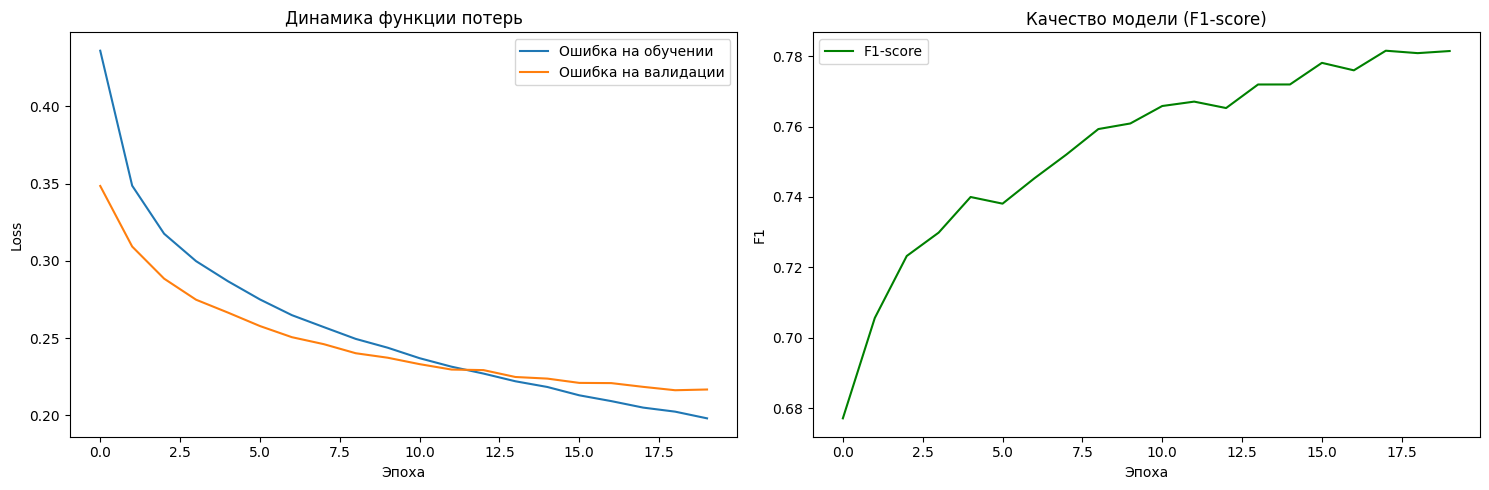

In [33]:
model_save_path = "my_models/my_best_text_cnn.pth"
num_epochs = 20
batch_size = 128
max_len = 100
embed_dim = 50

if __name__ == "__main__":
    y_train = torch.FloatTensor([list(map(int, lbl.split())) for lbl in train_part_labels])
    y_val = torch.FloatTensor([list(map(int, lbl.split())) for lbl in val_part_labels])

    vocab = TextVocabulary()
    vocab.build_from_texts(train_part_texts, max_size=10000)
    pad_idx = vocab.token_to_idx["[pad]"]

    train_dataset = TextDataset(train_part_texts, y_train, vocab, max_len)
    val_dataset = TextDataset(val_part_texts, y_val, vocab, max_len)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda b: pad_collate(b, pad_idx, max_len)
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda b: pad_collate(b, pad_idx, max_len)
    )

    model = TextCNN(
        vocab_size=len(vocab),
        embed_dim=embed_dim,
        num_classes=y_train.shape[1],
        kernel_sizes=(3, 4, 5),
        num_filters=100
    ).to(device)

    train_model(
        model,
        train_loader,
        val_loader,
        epochs=num_epochs,
        model_save_path=model_save_path
    )

    test_labels_dummy = [[0]*y_train.shape[1]] * len(test_texts)
    test_dataset = TextDataset(test_texts, test_labels_dummy, vocab, max_len)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda b: pad_collate(b, pad_idx, max_len)[0]
    )

    best_model = TextCNN(len(vocab), embed_dim, y_train.shape[1]).to(device)
    best_model.load_state_dict(torch.load(model_save_path))

    all_preds = []
    with torch.no_grad():
        for batch in test_loader:
            outputs = best_model(batch.to(device))
            preds = (torch.sigmoid(outputs) > 0.5).int()
            all_preds.extend(preds.cpu().numpy())

    submission = pd.DataFrame({
        'id': cleaned_test["id"],
        'labels': [' '.join(map(str, pred)) for pred in all_preds]
    })

    submission.to_csv("submission_df_text_cnn_.csv", index=False)

## Bert-like

In [21]:
class TextDataset(Dataset):
    def __init__(self, texts: pd.Series, labels: pd.Series, tokenizer, max_len: int):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label_str = self.labels.iloc[idx]
        label_list = [int(x) for x in label_str.split()]
        labels = torch.tensor(label_list, dtype=torch.float)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = TextDataset(texts=texts, labels=labels, tokenizer=tokenizer, max_len=max_len)
    return DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2)

BATCH_SIZE = 8
MAX_LEN = 256
EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=20,
    problem_type="multi_label_classification"
)
model = model.to(DEVICE)

train_data_loader = create_data_loader(train_part_texts, train_part_labels, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_part_texts, val_part_labels, tokenizer, MAX_LEN, BATCH_SIZE)

optimizer = AdamW(model.parameters(), lr=2e-5)  # теперь из torch.optim
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

loss_fn = torch.nn.BCEWithLogitsLoss().to(DEVICE)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    losses = []
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return np.mean(losses)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = loss_fn(logits, labels)
            losses.append(loss.item())

            preds = torch.sigmoid(logits).cpu().numpy()
            preds = (preds >= 0.5).astype(int)
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    f1 = f1_score(all_labels, all_preds, average='micro')
    acc = accuracy_score(all_labels, all_preds)

    return np.mean(losses), f1, acc

history = {'train_loss': [], 'val_loss': [], 'val_f1': [], 'val_acc': []}

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, DEVICE, scheduler)
    val_loss, val_f1, val_acc = eval_model(model, val_data_loader, loss_fn, DEVICE)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    history['val_acc'].append(val_acc)

    print(f'Train loss: {train_loss:.4f}')
    print(f'Val loss: {val_loss:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f}')



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Train loss: 0.3098
Val loss: 0.2278, F1: 0.9074, Acc: 0.1676
Epoch 2/5
Train loss: 0.1974
Val loss: 0.1812, F1: 0.9283, Acc: 0.2313
Epoch 3/5
Train loss: 0.1613
Val loss: 0.1661, F1: 0.9348, Acc: 0.2866
Epoch 4/5
Train loss: 0.1353
Val loss: 0.1551, F1: 0.9401, Acc: 0.3174
Epoch 5/5
Train loss: 0.1163
Val loss: 0.1518, F1: 0.9417, Acc: 0.3309


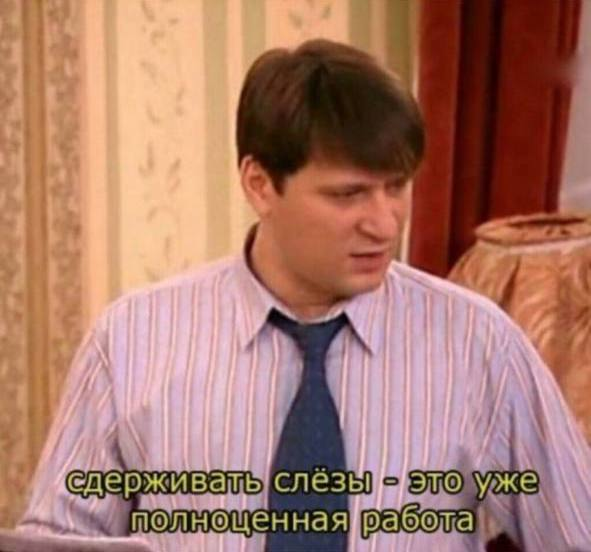

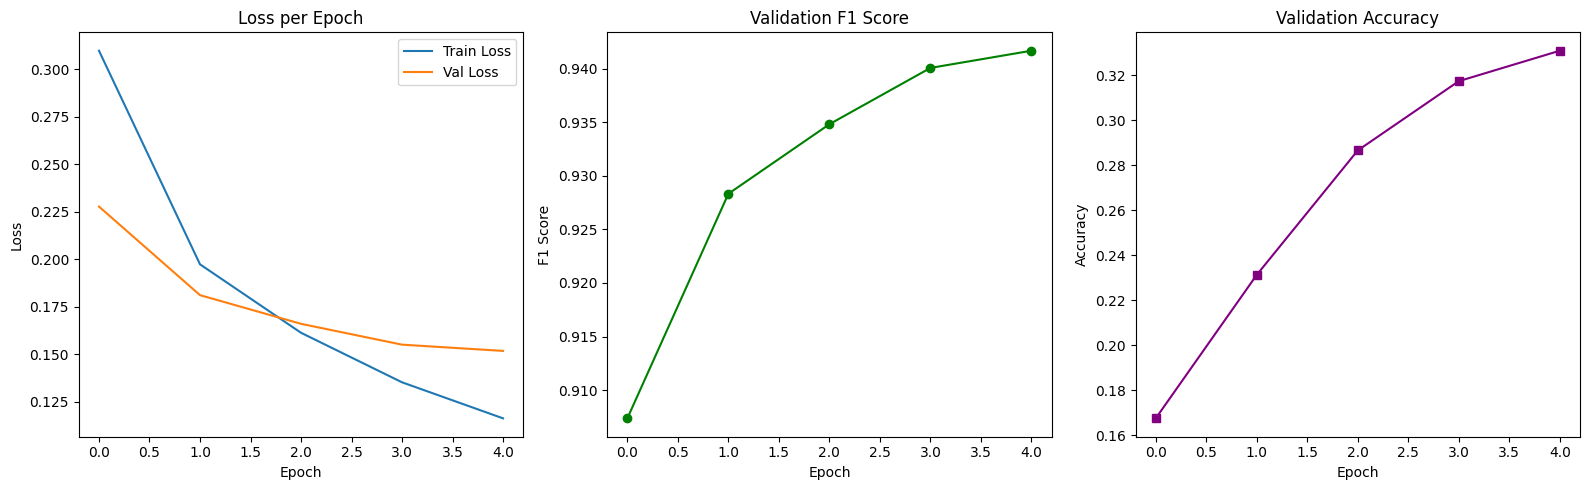

In [22]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['val_f1'], marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')

plt.subplot(1, 3, 3)
plt.plot(history['val_acc'], marker='s', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()


In [23]:
def predict_on_test(texts, model, tokenizer, max_len, batch_size=8):
    model.eval()
    test_dataset = TextDataset(texts=texts, labels=pd.Series(["0 " * 20] * len(texts)), tokenizer=tokenizer, max_len=max_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.sigmoid(logits).cpu().numpy()
            preds = (preds >= 0.5).astype(int)
            all_preds.append(preds)

    all_preds = np.vstack(all_preds)
    return all_preds


In [24]:
test_preds = predict_on_test(test_texts, model, tokenizer, MAX_LEN)

In [25]:
preds_str = [' '.join(map(str, row)) for row in test_preds]

submission = pd.DataFrame({
    'id': cleaned_test["id"],
    'labels': preds_str
})

submission.to_csv('submission_df_bert.csv', index=False)

## Обогащение текста

In [46]:
from transformers import AutoTokenizer, AutoModelWithLMHead
from tqdm import tqdm

In [44]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
model = AutoModelWithLMHead.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_text(prompt, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_length=max_length,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True).replace(prompt, "").strip()

def label_vector_to_prompt(label_vector):
    active_topics = [str(i) for i, val in enumerate(label_vector) if val == 1]
    return f"Новость про темы: {', '.join(active_topics)}."

num_to_generate = 1000
sampled_labels = train_part_labels.sample(n=num_to_generate, replace=True).values

def parse_label_row(row):
    if isinstance(row, str):
        return [int(val) for val in row.strip().split() if val.strip() != '']
    elif isinstance(row, (list, np.ndarray)):
        return list(map(int, row))
    else:
        raise ValueError("Неизвестный формат строки меток")

parsed_labels = [parse_label_row(row) for row in sampled_labels]

generated_texts = []
for label_vector in tqdm(parsed_labels, desc="Генерация текстов"):
    prompt = label_vector_to_prompt(label_vector)
    text = generate_text(prompt)
    generated_texts.append(text)

start_id = train_part["id"].max() + 1
augmented_df = pd.DataFrame({
    "id": range(start_id, start_id + num_to_generate),
    "text": generated_texts,
    "labels": [" ".join(map(str, lbl)) for lbl in parsed_labels]
})

train_part_augmented = pd.concat([train_part, augmented_df], ignore_index=True)
print(train_part_augmented)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:1949: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
Генерация текстов: 100%|██████████| 1000/1000 [04:22<00:00,  3.80it/s]

          id                                               text  \
0       7748  минимальный вложение собрать свой мероприятие ...   
1      24202  август мастер класс мозаика камень смальта мас...   
2      22719  мота мероприятие клубный формат начало меропри...   
3      24534  афиша афиша москва мероприятие выставка фестив...   
4      16068  июнь концерт команда жить клуб ящик здравствуй...   
...      ...                                                ...   
24649  30563  Не менее 20 заметок.  Ссылки: - "Все, что вы х...   
24650  30564  Обсуждение. \n Новости за 16-02-2013 \n В наст...   
24651  30565  Новости для студентов и школьников - 1, 2, 3, ...   
24652  30566   1-й выпуск -&nbsp;6 июня 2012\n\n\n35435312\tmar   
24653  30567  На эту тему: 0, 2, 3, 7, 8, 10.  На эту тему: ...   

                                        labels  
0      1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0  
1      1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0  
2      1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0  

На самом деле норм сгенерировал, могло бы быть хуже

> Как показал опыт обучения с новым "обогащенным" датасетом, **скора это не прибавляет**